<a href="https://colab.research.google.com/github/HassanSuhaib71/Learn-Langgraph-With-Hassan/blob/main/16_module_2_6_1_chatbot_external_memory_with_our_db_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_google_genai

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')


In [ ]:

import os
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [ ]:
import sqlite3


In [ ]:
conn = sqlite3.connect(":memory:", check_same_thread = False) #check_same_thread = False | allowing multiple threads to share and use the same SQLite database connection. By default it is True


#Default Behaviour

In [ ]:
import sqlite3
# pull file if it doesn't exist and connect to local db

!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2025-01-30 05:53:51--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2025-01-30 05:53:51--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.03s   

2025-01-30 05:53:51 (4.16 MB/s) - ‘s

#Mount with Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sqlite3
file_path = '/content/drive/My Drive/state_db/example.db'
conn = sqlite3.connect(file_path)

#When We want to upload file from local system instead from drive then we have to use the following method instead of above

In [ ]:
#Follow step if you already have previous database file
#uplaod example.db file from your system
from google.colab import files
uploaded = files.upload()

In [ ]:
#Follow step if you already have previous database file
#upload example.db-wal file from your system
uploaded = files.upload()

In [ ]:
#Follow step if you already have previous database file
#move both files to state_db folder and establish a connection:

import sqlite3
import shutil
import os

# Ensure the state_db directory exists
os.makedirs("state_db", exist_ok=True)

# Move the uploaded files to the state_db directory
shutil.move("example.db", "state_db/example.db")
if os.path.exists("example.db-wal"):  # Check if WAL file exists
    shutil.move("example.db-wal", "state_db/example.db-wal")
    print("WAL file moved successfully.")
else:
    print("No WAL file found. Proceeding with example.db only.")

# Define the path to the main database file
db_path = "state_db/example.db"

# Connect to the SQLite database
try:
    conn = sqlite3.connect(db_path, check_same_thread=False)
    print(f"Connected to database: {db_path}")
except sqlite3.OperationalError as e:
    print(f"Error connecting to the database: {e}")

#Graph

In [ ]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory: SqliteSaver = SqliteSaver(conn)

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash", api_key =  GEMINI_API_KEY)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State) -> State:

    # Get summary if it exists
    summary = state.get("summary", "")
    print(f"Using summary: {summary}")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State) -> State:
    print(f"Messages before summarizing: {len(state['messages'])}")
    # First, we get any existing summary
    summary = state.get("summary", "")
    print(f"Existing summary: {summary}")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"


    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    # Summarization logic
    print(f"New summary: {response.content}")

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    print(f"Messages after truncation: {len(delete_messages)}")
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> State:

    """Return the next node to execute."""

    messages = state["messages"]
    print(f"Message count: {len(messages)}")
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

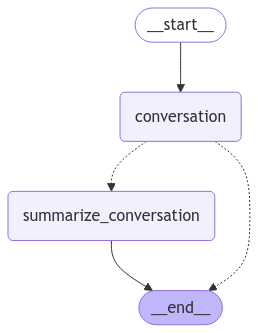

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph

# Define a new graph
workflow: StateGraph = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Create a thread
config2 = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="I would like to know about football.")
output = graph.invoke({"messages": [input_message]}, config2)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: The conversation began with a request for information about football (soccer).  After providing a general overview of the sport, the conversation shifted to a more personal level when the user revealed their name is Hassan.  Finally, Hassan declared their fandom for the San Francisco 49ers (an NFL team, not a soccer team), prompting a question about what specifically they enjoy about the team.
Message count: 4


ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139181764657152 and this is thread id 139180235474496.

In [ ]:
input_message = HumanMessage(content="My name is Hassan!")
output = graph.invoke({"messages": [input_message]}, config2)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: 
Message count: 4
================================== Ai Message ==================================

It's nice to meet you, Hassan!  Is there anything specific about football you'd like to know or discuss?  I'm happy to help in any way I can.


In [ ]:
input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config2)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: 
Message count: 6
================================== Ai Message ==================================

Your name is Hassan.


In [ ]:
input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config2)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: 
Message count: 8
Messages before summarizing: 8
Existing summary: 
New summary: The conversation began with a request for information about football (soccer).  After providing a general overview of the sport, the conversation shifted to a more personal level when the user revealed their name is Hassan.  Finally, Hassan declared their fandom for the San Francisco 49ers (an NFL team, not a soccer team), prompting a question about what specifically they enjoy about the team.
Messages after truncation: 6
================================== Ai Message ==================================

That's great!  The San Francisco 49ers are a very popular and historically successful NFL team.  What do you like most about them?  Their current season? A specific player?  Their history?  I'd love to hear more about your fandom.


In [ ]:
config2 = {"configurable": {"thread_id": "2"}}
graph_state = graph.get_state(config2)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='i like the 49ers!', additional_kwargs={}, response_metadata={}, id='5ec17c4d-06b6-4b6d-937a-aead4a1e9d2f'), AIMessage(content="That's great!  The San Francisco 49ers are a very popular and historically successful NFL team.  What do you like most about them?  Their current season? A specific player?  Their history?  I'd love to hear more about your fandom.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-b8815776-4100-4243-8812-af996617c570-0', usage_metadata={'input_tokens': 695, 'output_tokens': 58, 'total_tokens': 753, 'input_token_details': {'cache_read': 0}})], 'summary': 'The conversation began with a request for information about football (soccer).  After providing a general overview of the sport, the conversation shifted to a more personal level when the user revealed their name is Hassan.  Finally, Hassan declar

In [ ]:
config2 = {"configurable": {"thread_id": "2"}}
messages = graph.get_state(config2).values.get("messages")
len(messages)

2

In [ ]:
graph_state = graph.get_state(config2).values.get("summary","")
graph_state

'The conversation began with a request for information about football (soccer).  After providing a general overview of the sport, the conversation shifted to a more personal level when the user revealed their name is Hassan.  Finally, Hassan declared their fandom for the San Francisco 49ers (an NFL team, not a soccer team), prompting a question about what specifically they enjoy about the team.'